# Stable Diffusion API: Image Generation & Editing

This notebook uses the Stable Diffusion API to first generate an image from a text prompt and then edit that image with a second prompt. Below, the code and commentary explain each step and share reflections on the API’s ease-of-use.

I generate an image using a text prompt and subsequently edit the generated image with an additional prompt. The workflow serves as both a demonstration of the Stable Diffusion API and a narrative on its usability.

In [12]:
import requests
import json
from PIL import Image
import math
from pprint import pprint as pp
from diffusers import StableDiffusionXLPipeline, StableDiffusionXLImg2ImgPipeline, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker
from transformers import CLIPImageProcessor, CLIPTokenizer
import torch

## 1. Image Generation

I generate an image from the prompt **"Literal hell. Brimestone, flying demons, souls down the river Styx."**. This step showcases the API’s ability to convert textual descriptions into detailed visuals. The pipeline uses the standard Hugging Face approach for loading a pretrained model (runwayml/stable-diffusion-v1-5) with StableDiffusionPipeline.from_pretrained, torch_dtype=torch.float16, and .to("cuda"). However, I override the tokenizer with one from stabilityai/stable-diffusion-xl-base-1.0. This is a non-standard customization, as I intended to experiment with different prompt encoding behaviors or leverage SDXL's tokenizer features within the v1.5 pipeline. Additionally, I set the number of inference steps to 125, increasing generation time in exchange for higher image fidelity and detail.

In [13]:
pipe = StableDiffusionPipeline.from_pretrained(
# StableDiffusionXLPipeline.from_pretrained(
#     "stabilityai/stable-diffusion-xl-base-1.0",
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
).to("cuda")

pipe.tokenizer = CLIPTokenizer.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0"
    , subfolder="tokenizer"
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [30]:
prompt = "Literal hell. Brimestone, flying demons, souls down the river Styx."
image = pipe(
    prompt
    ,num_inference_steps=125
).images[0]

  0%|          | 0/125 [00:00<?, ?it/s]

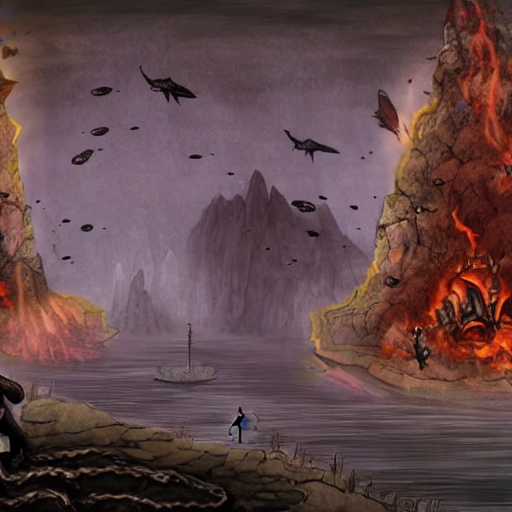

In [31]:
image

## 2. Advanced Image Generation with SDXL and Refiner Pipeline

The use of StableDiffusionXLPipeline and its associated StableDiffusionXLImg2ImgPipeline refiner reflects a shift toward a more advanced and modular image generation workflow using the Stable Diffusion XL (SDXL) architecture. SDXL offers significant improvements in visual fidelity, semantic alignment, and fine-grained detail compared to earlier models like v1.5.

I load the base pipeline (pipe_explicit) from stabilityai/stable-diffusion-xl-base-1.0 with torch_dtype=torch.float16 and variant="fp16" to optimize memory usage and performance on the GPU. I enable VAE slicing and xFormers memory-efficient attention to further reduce VRAM consumption, allowing for larger or more complex generations without out-of-memory errors. Enabling model CPU offloading provides additional memory savings by dynamically shifting parts of the model between CPU and GPU as needed.

For refinement, I use StableDiffusionXLImg2ImgPipeline (pipe_explicit_refiner) from stabilityai/stable-diffusion-xl-refiner-1.0. I pass in components from the base pipeline—text_encoder_2 and vae—to maintain consistency between the base generation and the refinement stage. The refiner is designed to operate on the latent outputs from the base pipeline, enhancing textures, edges, and lighting to produce a final image of higher quality and coherence.

The two-stage process begins with generating latent representations from the base model using 25 inference steps—a lower step count to reduce initial compute load while still capturing core structure. Then, the refiner enhances the image from those latents, guided by the same prompt. This modular approach allows for better control, optimization, and output fidelity in high-end image synthesis tasks.

In [32]:
pipe_explicit = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    ).to("cuda")
pipe_explicit.enable_vae_slicing()
pipe_explicit.enable_xformers_memory_efficient_attention()
pipe_explicit.enable_model_cpu_offload()
pipe_explicit_refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0"
    ,text_encoder_2=pipe_explicit.text_encoder_2
    ,vae=pipe_explicit.vae
    ,torch_dtype=torch.float16
    ,variant="fp16"
    ).to("cuda")
pipe_explicit_refiner.enable_vae_slicing()
pipe_explicit_refiner.enable_xformers_memory_efficient_attention()
pipe_explicit_refiner.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, text_encoder_2, tokenizer, tokenizer_2, unet, image_encoder, feature_extractor, scheduler to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


In [43]:
with torch.inference_mode():
    image_explicit = pipe_explicit_refiner(
        prompt=prompt
        ,image=image
    ).images[0]

  0%|          | 0/15 [00:00<?, ?it/s]

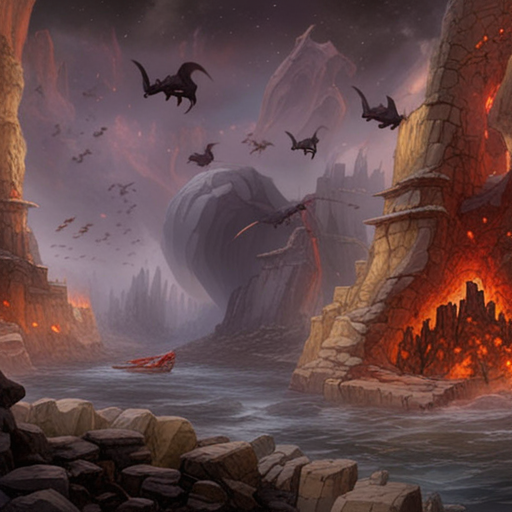

In [44]:
image_explicit

## 3. Image Editing

Now I apply an edit to the generated image by using the SDXL Img2Img pipeline with a modified prompt. The edit aims to transform the existing scene into a more serene and less apocalyptic version, changing the tone while retaining the original structure. I set strength=0.5 to allow a balanced blend between the existing composition and the new prompt — enough influence to shift the mood, but not so strong that it overrides core visual elements like the rocky terrain and water. The guidance_scale=8.0 was chosen to ensure the model strongly adheres to the prompt's descriptive intent (removing demons, adding soft light), without becoming overly rigid or sacrificing creative variation.

  0%|          | 0/25 [00:00<?, ?it/s]

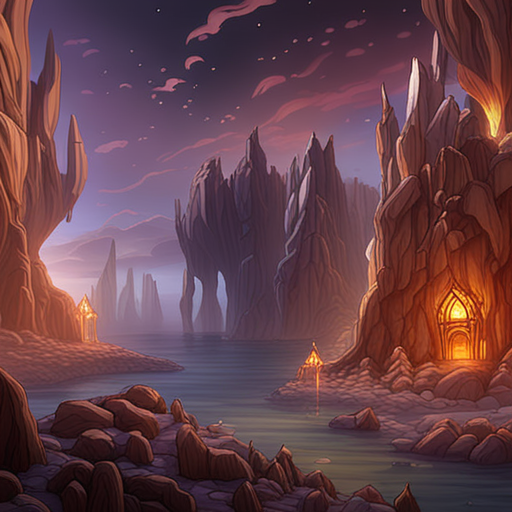

In [45]:
edited_prompt = "a peaceful fantasy landscape with bright skies, no dragons, calm water, glowing crystals, and soft ambient light"

with torch.inference_mode():
    edited_image = pipe_explicit_refiner(
        prompt=edited_prompt,
        image=image_explicit,
        strength=0.5,
        guidance_scale=8.0,
    ).images[0]

edited_image

  0%|          | 0/25 [00:00<?, ?it/s]

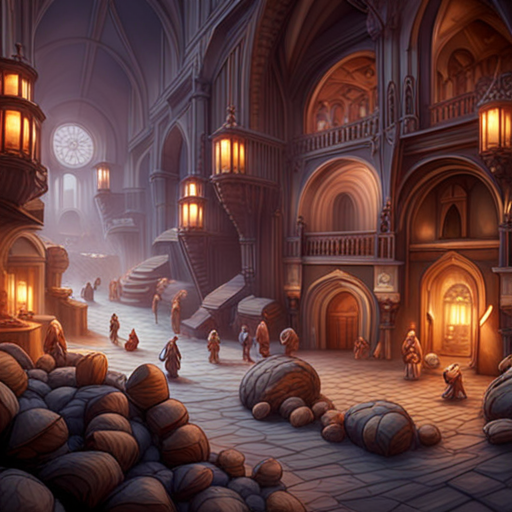

In [49]:
edited_prompt_v2 = "hyper realistic sprawling with hundreds of dwarves bustling about"

with torch.inference_mode():
    edited_image_v2 = pipe_explicit_refiner(
        prompt=edited_prompt_v2,
        image=edited_image,
        strength=0.5,
        guidance_scale=8.0,
    ).images[0]

edited_image_v2

## Narrative and Reflections

The edit softened the harsh atmosphere of the original image, replacing the fiery sky and dragons with calm lighting and a peaceful fantasy vibe. The strength parameter at 0.5 allowed for a good balance between the original layout and the new prompt.

Using the Stable Diffusion API in a Jupyter Notebook was impressively smooth. The pipeline structure is intuitive, and customization options like prompt tuning, model offloading, and two-stage refinement made it powerful yet accessible. Editing with only a few lines of code felt easy, especially with built-in support for GPU acceleration and efficient memory handling.